# Citation Network Simulation

This program is broken into three parts:
1. Creating the graph/network
2. Determining phrases within the the network,
3. Identifying sharing/exposed nodes and performing the estimate. 

The results of all calculations are written to a backup folder; use the get functions (e.g. getDict or getFile) to import calculations.

In [5]:
#Imports
import collections
import nltk
from nltk.collocations import *
import math
import os
import json
import numpy as np
import csv
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import bernoulli
from scipy.stats import pareto
import networkx as nx
import random
import scipy.io
import collections
import pickle
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition,mark_inset)
import copy

In [6]:
"""
Name: nonblankLines
Inputs: A line
Purpose: Handles files with blank lines
"""
def nonblankLines(f):
    for l in f:
        line = l.rstrip()
        line = line.replace('\n','')
        if line:
            yield line


In [7]:
"""
Name: listToFile
Input: A list and a file to write to
Purpuse: Writes the list in a file
"""
def listToFile(items,writefile):
    with open(writefile,'w',encoding="utf8") as output:
        for item in items:
            output.write("%s\n" % item)
    output.close()


In [8]:
"""
Name: getDict
Inputs: A file to read from
Purpose: Returns a dictionary
"""
def getDict(file):
    #Reading the data from a file
    with open(file,encoding="utf8") as f:
        data = f.read()
    f.close()

    return json.loads(data)

In [9]:
"""
Name: getList
Inputs: A file to read from
Purpose: Returns a list
"""
def getList(readfile):
    item = []
    with open(readfile, 'r', encoding="utf8") as input:
        for lines in input:
            item.append(lines)
    input.close()
    return item

In [10]:
"""
Name: search
Inputs: list and dictionary
Purpose: To search a list of key and determine
"""
def search(listOfItems, dict):
    for i in range(len(listOfItems)):  # search to see if friend shared
        #print(dict[str(listOfItems[i])])
        if dict[int(listOfItems[i])] == 1:
            return True
    return False

In [11]:
"""
Name: validKey
Inputs: A dictionary and an item
Purpose: Determines if item is a key
         in the dictionary
"""
def validKey(dict, key):
    if key in dict.keys():
        return True
    else:
        return False

In [12]:
"""
Name: truncate
Inputs: A float and number
Purpose: Truncates/pads a float f to n decimal places without rounding
"""
def truncate(f, n):
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [13]:
"""
Name: createHashtable
Inputs: nodes
Purpose: Creates a dictionary with the nodes as the keys and the index as the value
"""
def createHashtable(nodes):
    hashtable = {}
    for i in range(len(nodes)):
        hashtable[nodes[i]] = i
    return hashtable

## Part I- Creating the graph/network

In [14]:
"""
Name: parseFile
Inputs: A file to read from and a file to write to
Purpose: Writes the data in a more legible format
"""
def parseFile(readfile, writefile="revisedACM.txt"):
    #Opening & iterating through the file
    with open(readfile, 'r', encoding="utf8") as infile, \
            open('backupFiles/{}'.format(writefile), 'w', encoding="utf8") as outfile:

        #Cleaning up the data
        for line in infile:
            line = line.replace("#", "")
            line = line.replace("index", "ID: ",1)
            line = line.replace("*", "Title: ")
            line = line.replace("%", "Reference: ")

            #Only writing the titles, IDs, and references to a new file
            if line.startswith("Title: ") or line.startswith("ID: ") \
                    or line.startswith("Reference: ") :
                    outfile.write(line)

    #Closing the files
    outfile.close()
    infile.close()

In [15]:
"""
Name: createPapers
Inputs: A file to read from and a file to write to
Purpose: Creates a dictionary with a paper's ID as the key
         and references and title as the value
"""
def createPapers(readfile = "revisedACM.txt", writefile="papers.txt"):
    #Initializing the dictionary and temporary variables
    paper = {}
    reference = []
    title =""
    ID = -1

    #Opening & iterating through the file
    with open('backupFiles/{}'.format(readfile), 'r', encoding="utf8") as input:
        for lines in input:

            #Determining the title
            if lines.startswith("Title: "):
                #Adding paper to the dictionary of papers
                paper[int(ID)] = [reference,title]

                #Resetting the temporary variables
                reference = []
                title = ""
                ID = ""

                #Removes the word 'Title' from the line
                title = lines.split(' ', 1)[1].lower()
                title = title.replace('\n','')

            #Determining the ID
            elif lines.startswith("ID: "):
                ID = int(lines.split(' ', 1)[1])

            #Determining the references
            elif lines.startswith("Reference: "):
                reference.append(int(lines.split(' ', 1)[1]))

    #Deleting the temporary paper from the dictionary
    del paper[-1]

    #Writing to the file
    with open('backupFiles/{}'.format(writefile), 'w') as output:
        output.write(json.dumps(paper))
    output.close()

    return paper

In [16]:
"""
Name: createNetwork
Inputs: A dictionary of papers and a file to write to
Purpose: To create a dictionary with a paper and its references
         nodes -> following
"""
def createNetwork(papers, writefile='network.txt'):
    #Initiliazing the dictionary
    networkDictionary = {}

    #Iterating through the papers
    for key, value in papers.items():
        #Only adding papers with references to the network
        if len(value[0]) >= 1:
            networkDictionary[int(key)] = value[0]

    #Writing to the file
    with open('backupFiles/{}'.format(writefile), 'w') as output:
        output.write(json.dumps(networkDictionary))
    output.close()

    return networkDictionary

In [17]:
"""
Name: createReverseNetwork
Inputs: The network and a file to write to
Purpose: To create a dictionary with a paper and others that referenced it
         nodes -> followers
"""
def createReverseNetwork(net, writefile='reversedNetwork.txt'):
    #Initiliazing the dictionary
    reverse = {}

    #Iterating through the network
    for key,value in net.items():
        #Switching the order from node-> following to node->followers
        for i in range(len(value)):
            reverse.setdefault(int(value[i]), [])
            reverse[int(value[i])].append(int(key))

    #Writing to the file
    with open('backupFiles/{}'.format(writefile), 'w') as output:
        output.write(json.dumps(reverse))
    output.close()

    return reverse

In [18]:
"""
Name: createEdgelist
Inputs: The network and a file to write to
Purpose: Writes the head and tail of a link (i.e. edge)
"""
def createEdgelist(network,file="edgeList.txt"):
    #Creating file with edge lists
    fileName = open('backupFiles/{}'.format(file),"w",encoding="utf8")
    for key,value in network.items():
        for j in range(len(value)):
            writer = csv.writer(fileName,delimiter= '\t')
            writer.writerows(zip([key],[value[j]]))
    fileName.close()

In [19]:
"""
Name: createGraph
Inputs: A file to read from
Purpose: Creates a graph using networkx
"""
def createGraph(file="edgeList.txt"):        
    # Generating the graph
    G = nx.Graph()
    edges = nx.read_edgelist('backupFiles/{}'.format(file))
    G.add_edges_from(edges.edges)
    return G

In [20]:
"""
Name: identifyNodes
Inputs: The reversed network and a file to write to
Purpose: Determines the total number of nodes in the network
"""
def identifyNodes(reverseNetwork, writefile="nodes.txt"):
    #Initiliazing the dictionary
    Nodes = {}

    #Iterating through the network
    for key,value in reverseNetwork.items():
        #Determining if node is already in the nodes dictionary
        if not validKey(Nodes,int(key)):
            #Adding nodes that have followers
            Nodes[int(key)]= ""

        #Iterating through nodes that are followers
        for j in range(len(value)):
            # Determining if node is already in the nodes dictionary
            if not validKey(Nodes,int(value[j])):
                #Adding nodes to the dictionary
                Nodes[int(value[j])]= ""

    #Writing to the file
    with open('backupFiles/{}'.format(writefile),'w') as output:
        output.write(json.dumps(Nodes))
    output.close()

    return Nodes

In [21]:
"""
Name: nodesWithFollowers
Inputs: A dictionary
Purpose:Returns a dictionary of nodes with followers (if given reverseNet)
        or a list of friends (if given Net)
"""
def nodesWithFollowersorFriends(reverseNetwork):
    hasFollowers ={}
    for key,value in reverseNetwork.items():
        hasFollowers[int(key)]=""
    return hasFollowers

In [22]:
"""
Name: identifyOutDegreeOfNodes
Inputs: The nodes, reversed network, and a file to write to
Purpose: Writes the out degree of each node to a file
"""
def identifyOutDegreeOfNodes(nodes,reverseNetwork,writefile="outDegree.txt"):
    d = {}
    hasFollowers = nodesWithFollowersorFriends(reverseNetwork)

    # Iterating through list of nodes
    for key,value in nodes.items():
        # if node has followers, add the amount of followers
        if validKey(hasFollowers,int(key)):
            d[int(key)] = len(reverseNetwork[key])
        else:
            d[int(key)] = 0

    #writing to file
    with open('backupFiles/{}'.format(writefile),'w') as convert_file:
        convert_file.write(json.dumps(d))
    convert_file.close()

    return d

In [23]:
"""
Name: identifyInDegreeOfNodes
Inputs: The nodes, network, and a file to write to
Purpose: Writes the degree of each node to a file
"""
def identifyInDegreeOfNodes(nodes, Network, writefile="inDegree.txt"):
    d = {}
    hasFriends = nodesWithFollowersorFriends(Network)

    # Iterating through list of nodes
    for key,value in nodes.items():
        # if the node has friends, add the amount of friends
        if validKey(hasFriends,int(key)):
            d[int(key)] = len(Network[key])
        else:
            d[int(key)] = 0

    #writing to file
    with open('backupFiles/{}'.format(writefile), 'w') as convert_file:
        convert_file.write(json.dumps(d))
    convert_file.close()

    return d

## Part II- Identifying phrases

In [24]:
"""
Name: titlesInNetwork
Inputs: The nodes, papers, and a file to write to
Purpose: Determines titles of papers in the network and
         writes the results to a file
"""
def titlesInNetwork(nodes,papers,writefile="titlesInNetwork.txt"):
    with open('backupFiles/{}'.format(writefile),'w',encoding="utf8") as f:
        # Finds the titles with the hashtag and records the ID
        for key, value in nodes.items():
            f.write(papers[int(key)][1])
            f.write("\n")
    f.close()

In [25]:
"""
Name: titlesCount
Inputs: A file with a list of phrases
Purpose: Determines how often a phrase appears in the network
"""
def titlesCount(phrases,titles="titlesInNetwork.txt"):
    counts = []
    with open(phrases,'r',encoding="utf8") as file1:
        for hashtag in file1:
            count = 0
            hashtag = hashtag.lower().replace('\n', '')
            with open('backupFiles/{}'.format(titles),'r',encoding="utf8") as file2:
                for title in nonblankLines(file2):
                    title = title.replace(".", "")
                    title = title.replace(",", "")
                    title = title.replace(":", "")
                    title = title.replace("\"", "")
                    title = title.replace("!", "")
                    title = title.replace("!", "")
                    title = title.replace("â€œ", "")
                    title = title.replace("â€˜", "")
                    title = title.replace("*", "")
                    if hashtag in title:
                        count = count+1
                file2.close()
            counts.append(count)
            print(hashtag, "appears ", count, " times")
        file1.close()

    with open("backupFiles/totalCounts.txt", 'w') as f:
        for item in counts:
            f.write("%s\n" % item)
        f.close()

In [26]:
"""
Name: findKeyWords
Inputs: A filename, a string, and the number
        of the words. The string is not case sensitive;
        possbilities are "Least", "Most", or "Average
Purpose: To determine the most/least popular words
"""
def findKeyWords(name,popularity,n_print,writefile="keywords.txt"):

    #List of words
    listOfWords = []

    # Stopwords
    stopwords = set(line.strip() for line in open('Stopwords.txt'))

    # Instantiate a dictionary, and for every word in the file,
    # Add to the dictionary if it doesn't exist. If it does, increase the count.
    wordcount = {}
    with open('backupFiles/{}'.format(name),'r',encoding="utf8") as infile:
        for lines in infile:
                # To eliminate duplicates, remember to split by punctuation, and use case demiliters.
                for word in lines.lower().split():
                    word = word.replace(".", "")
                    word = word.replace(",", "")
                    word = word.replace(":", "")
                    word = word.replace("\"", "")
                    word = word.replace("!", "")
                    word = word.replace("â€œ", "")
                    word = word.replace("â€˜", "")
                    word = word.replace("*", "")
                    if word not in stopwords:
                        if word not in wordcount:
                            wordcount[word] = 1
                        else:
                            wordcount[word] += 1

    # Close the file
    infile.close()

    #updates word_counter so that only words with 200+ uses are counted
    word_counter = collections.Counter(wordcount)
    for k in list(word_counter.keys()):
        if word_counter[k] < 500: #orginally was 200
            del word_counter[k]

    #Handles the popularity metric
    with open('backupFiles/{}'.format(writefile),'w',encoding="utf8") as file:
        if popularity.lower() == "most":
            file.write("The {} most common words are \n".format(n_print))
            for word, count in word_counter.most_common(n_print):
                data = str(word)+": "+str(count)+"\n"
                file.write(data)
                listOfWords.append(word)

        elif popularity.lower() == "least":
            file.write("The {} least common words are \n".format(n_print))
            for word, count in word_counter.most_common()[:-n_print - 1:-1]:
                data = str(word)+": "+str(count)+"\n"
                file.write(data)
                listOfWords.append(word)

        elif popularity.lower() == "average":
            file.write("{} words in the middle are \n".format(n_print))
            middle = math.ceil(len(word_counter)/2)
            beginning = middle-(n_print/2)
            end = middle+(n_print/2)
            for word, count in word_counter.most_common()[int(beginning):int(end):1]:
                data = str(word)+": "+str(count)+"\n"
                file.write(data)
                listOfWords.append(word)

    return listOfWords

In [27]:
"""
Name: findKeyPhrases
Inputs: A filename, a string, and the number
        of the phrases. The string is not case sensitive;
        possbilities are "Least", "Most", or "Average
Purpose: To determine the most/least popular phrases
"""
def findKeyPhrases(popularity,n_print,filename="titlesInNetwork.txt",writefile="keyphrases.txt"):

    popularWords = findKeyWords(filename,popularity,n_print) 
    with open('backupFiles/{}'.format(writefile),'w',encoding="utf8") as file:
        #iterates through common words
        for i in range(len(popularWords)):
            with open('backupFiles/{}'.format(filename), 'r', encoding="utf8") as f:
                tokens = f.read().split()

            bigram_measures = nltk.collocations.BigramAssocMeasures()

            word_filter = lambda *w: popularWords[i] not in w

            ## Bigrams
            finder = BigramCollocationFinder.from_words(tokens)

            # only bigrams that appear 3+ times
            finder.apply_freq_filter(100) #originally 3

            # only bigrams that contain the popular word
            finder.apply_ngram_filter(word_filter)

            # return the 5 n-grams with the highest PMI; could change the n-grams value to vary n phrases per word
            data = str(finder.nbest(bigram_measures.likelihood_ratio, 10)) + "\n" #originally was 5
            file.writelines(data)

        #closes titles file
        f.close()
    #closes keyphrase file
    file.close()

## Part III- Identifying shared/exposed nodes and performing estimation

In [28]:
""" 
Name: identifySharingNodes
Inputs: A common phrase, the list of papers,nodes, a file
Purpose: Writes the sharing status of each node to a file
"""
def identifySharingNodes(phrase, papers, nodes, writefile="sharingNodes.txt"):
    shared = {}

    #Finds the titles with the hashtag and records the ID
    for key,value in nodes.items():
        title = papers[int(key)][1]
        if phrase in title:
            shared[int(key)] = 1
        else:
            shared[int(key)] = 0

    #writing to file
    with open('backupFiles/{}'.format(writefile),'w') as convert_file:
        convert_file.write(json.dumps(shared))

    return shared

In [29]:
"""
Name: identifyExposedNodes
Inputs: a list of sharers, the reversed network
Purpose: To create a list of followers that were exposed
"""
def identifyExposedNodes(shared,forwardNetwork,writefile="exposedNodes.txt"):
    exposed = {}

    for key,value in shared.items():
        if shared[int(key)] == 1: #if the node shared, then it's exposed
            exposed[int(key)] = 1
        elif validKey(forwardNetwork,str(key)): #if the node follows people
            friends = list(forwardNetwork[str(key)])
            if search(friends,shared): #search to see if friend shared
                exposed[int(key)] = 1 #if friend shared, then exposed
            else:
                exposed[int(key)] = 0
        else: #if node didn't share, nor followed someone who shared, then not exposed
            exposed[int(key)] = 0

    #writing to file
    with open('backupFiles/{}'.format(writefile),'w') as convert_file:
        convert_file.write(json.dumps(exposed))

    return exposed

In [30]:
# Nodes : List of nodes [1,2,3....]
# d_out : d_out[i] is the out-degree (number of papers that cited paper i)
# d_in : d_in[i] is the in-degree (number of papers that paper i cited)
# s : s[i] = 1 if i is shared, s[i] = 0 otherwise
# f : f[i] = 1 if i is exposed, f[i] = 0 otherwise (This has to be constructed)

def MeanAbsError(n_list, No_iterations = 100):
    #Dictionary for storing the results for various n values
    Dict_Results = {}
    
    #Creates a dictionary with the node # as the key and the index as the value
    hashtable = createHashtable(Nodes)
  
    # The following for-loop considers different values of the sample size
    for n in n_list:

        #Vectors to store the estimates from the two methods
        Estimate_X_vec_error = []
        Estimate_Y_vec_error = []
        Estimate_Z_vec_error = []       

        i = 0
        # The following while loop generates vanilla and friendship paradox based MLEs in each iteration        
        while i < No_iterations: 

            # Sampling n Random Nodes (X_1, X_2,....X_n) independently from the set of nodes of the network G
            X_nodes = list(np.random.choice(Nodes, size=n))

            # Sampling n Random Friends (Y_1, Y_2,....Y_n) independently (version-1 of friendship paradox)
            Y_nodes = list(np.random.choice(Nodes, size=n, p = np.array(d_out)/sum_degree_out)) 
            
            # Sampling n Random Followers (Y_1, Y_2,....Y_n) independently (version-2 of friendship paradox)
            Z_nodes = list(np.random.choice(Nodes, size=n, p = np.array(d_in)/sum_degree_in)) 
        
            # Computing the vanilla estimate
            print("Iteration: ", i,"/",No_iterations, "  in List",n,"/",n_list)
            f_hat_vanilla = sum([f[hashtable[v]] for v in X_nodes])/n
            Estimate_X_vec_error.append(np.abs(f_hat_vanilla - bar_f)*100/bar_f)

            # Computing the friendship paradox based method (followers)
            f_hat_FP1 = sum([(bar_d * f[hashtable[v]]/d_out[hashtable[v]]) for v in Y_nodes])/n
            Estimate_Y_vec_error.append(np.abs(f_hat_FP1 - bar_f)*100/bar_f)
            
            # Computing the friendship paradox based method (friends)
            f_hat_FP2 = sum([(bar_d * f[hashtable[v]]/d_in[hashtable[v]]) for v in Z_nodes])/n
            Estimate_Z_vec_error.append(np.abs(f_hat_FP2 - bar_f)*100/bar_f)
            
            i = i + 1

        #Storing the values in a dictionary in compact form
        Dict_Results[n] = (n, bar_f, np.corrcoef(d_out, s)[0,1], np.mean(Estimate_X_vec_error), np.mean(Estimate_Y_vec_error),np.mean(Estimate_Z_vec_error))
        
    return Dict_Results

In [31]:
## Generating the results and saving
def SaveError(G, s, GraphName):

    n_list = [int(np.ceil(x*len(G.nodes()))) for x in [0.001, 0.002, 0.003, 0.004, 0.005]]
            
    Dict_Name = 'Results/' + GraphName
    Dict_Results = MeanAbsError(n_list, No_iterations = 5000)    

    try:
        import cPickle as pickle
    except ImportError:  
        import pickle
    with open(Dict_Name, 'wb') as fp:
       pickle.dump(Dict_Results, fp, protocol=pickle.HIGHEST_PROTOCOL)

    (n, bar_f, p_ks, Vanilla_error, FP_error_1,FP_error_2) = zip(*list(Dict_Results.values()))               
    print(GraphName + r'$r_{kk}$ = ' + str(nx.degree_assortativity_coefficient(G)))
    print('p_ks (actual)= ' + str(p_ks[0]))    
    print(r'$\bar{f} = $' + str(bar_f[0]))                
    print('')                

In [32]:
## Loading the results and plotting
def PlotError(G,GraphName):
    %matplotlib inline
    import matplotlib.pylab as pl

    matplotlib.rc('xtick', labelsize=4) 
    matplotlib.rc('ytick', labelsize=4) 

    MARKERS = ['s','o','x']

    n_list = [int(np.ceil(x*len(G.nodes()))) for x in [0.001, 0.002, 0.003, 0.004, 0.005]]
    
    Dict_Name = 'Results/' + GraphName

    try:
        import cPickle as pickle
    except ImportError:  
        import pickle
    with open(Dict_Name, 'rb') as fp:
        Dict_Results = pickle.load(fp)            

    (n, bar_f, p_ks, Vanilla_error, FP_error_1,FP_error_2) = zip(*list(Dict_Results.values()))
    plt.plot(n, Vanilla_error, #For percentage error                                         
                  label = r'$\hat{f}_{\mathrm{vl}}$',
                  color = 'tab:grey', 
                  marker = 's',
                  markersize = 3.5,  
                  markerfacecolor = 'none',                          
                  linestyle = '--',
                  linewidth = 0.75                      
                 )

    plt.plot(n, FP_error_1, #For percentage error                           
                  label = r'$\hat{f}_{\mathrm{FP}}$',
                  color = 'tab:olive',
                  marker = 'o',  
                  markersize = 3.5,      
                  markerfacecolor = 'none',                        
                  linestyle = ':' ,                         
                  linewidth = 0.75
                 )   
    
    plt.plot(n, FP_error_2, #For percentage error                           
                  label = r'$\hat{f}_{\mathrm{FP}}$',
                  color = 'tab:purple',
                  marker = 'x',  
                  markersize = 3.5,      
                  markerfacecolor = 'none',                        
                  linestyle = ':' ,                         
                  linewidth = 0.75
                 )  

    print(GraphName + r'$r_{kk}$ = ' + str(nx.degree_assortativity_coefficient(G)))                       
    print('p_ks (actual)= ' + str(p_ks[0]))    
    print(r'$\bar{f} = $' + str(bar_f[0]))                
    print('')                

    # Setting the x and y labels    
    plt.xlabel(r'Sample size $n$', fontsize=15, labelpad=1)
    plt.ylabel(r'Absolute Error (%)', fontsize=15, labelpad=1)
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 15)
    plt.ylim([0,260])
    plt.legend(loc='upper center', bbox_to_anchor=(0.35, 1.2),ncol=3)
    plt.gcf().text(0.67, 0.87, textstr, fontsize=12)  
    plt.tight_layout()  
    
    #Saving the plot
    GraphName = GraphName.replace(".txt",".png")
    name = 'Results/Figures/{}'.format(GraphName)
    plt.savefig(name)


In [48]:
#Takes all the files in the folder and determines the average with error bars
def PlotErrorAveragewith_error_bars(G,directory):
    %matplotlib inline
    import matplotlib.pylab as pl

    matplotlib.rc('xtick', labelsize=4) 
    matplotlib.rc('ytick', labelsize=4) 

    MARKERS = ['s','o','x']
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7.0, 1.8))

    n_list = [int(np.ceil(x*len(G.nodes()))) for x in [0.001, 0.002, 0.003, 0.004, 0.005]]
    j = 0
    
    #walking through folder
    for rootdir, dirs, files in os.walk(directory):
        #walking through subfolder
        for subdir in dirs:
            
            #resetting the dictionaries
            f ={}
            pks = {}
            vanilla ={}
            fp1 ={}
            fp2 ={}
            path = os.path.join(directory, subdir)
            
            #getting files in subfolder
            for (dirpath, dirnames, filenames) in os.walk(path):
                for file in filenames:
                    try:
                        import cPickle as pickle
                    except ImportError:  
                        import pickle

                    with open(os.path.join(dirpath, file), "rb") as fp:
                        Dict_Results = pickle.load(fp)
                        (n, bar_f, p_ks, Vanilla_error, FP_error_1,FP_error_2) = zip(*list(Dict_Results.values()))

                        #updating the dictionary
                        for i in range(len(n)):
                            if n[i] in f:
                                f[n[i]].append(bar_f[i])
                                pks[n[i]].append(p_ks[i])
                                vanilla[n[i]].append(Vanilla_error[i])
                                fp1[n[i]].append(FP_error_1[i])
                                fp2[n[i]].append(FP_error_2[i])

                            else:
                                f[n[i]] = [bar_f[i]]
                                pks[n[i]] = [p_ks[i]]
                                vanilla[n[i]] = [Vanilla_error[i]]
                                fp1[n[i]] = [FP_error_1[i]]
                                fp2[n[i]] = [FP_error_2[i]]

            vanilla_mean,vanilla_error,fp1_mean,fp1_error,fp2_mean,fp2_error =([] for i in range(6))
    
            #Determining averages and standard deviation for each point
            for i in range(len(n_list)):
                vanilla_mean.append(np.nanmean(vanilla[n_list[i]]))
                vanilla_error.append(np.nanstd(vanilla[n_list[i]]))
                fp1_mean.append(np.nanmean(fp1[n_list[i]]))
                fp1_error.append(np.nanstd(fp1[n_list[i]]))
                fp2_mean.append(np.nanmean(fp2[n_list[i]]))
                fp2_error.append(np.nanstd(fp2[n_list[i]]))

            ax[j].errorbar(n, vanilla_mean, #For percentage error 
                          yerr = vanilla_error,
                          label = r'$\hat{f}_{\mathrm{vl}}$',
                          color = 'tab:red', 
                          marker = 's',
                          markersize = 3.5,  
                          markerfacecolor = 'none',                          
                          linestyle = '--',
                          linewidth = 0.75                      
                         )

            ax[j].errorbar(n, fp1_mean, #For percentage error  
                          yerr = fp1_error,
                          label = r'$\hat{f}_{\mathrm{FP}}$',
                          color = 'tab:green',
                          marker = 'o',  
                          markersize = 3.5,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.75
                         )   

            ax[j].errorbar(n, fp2_mean, #For percentage error 
                          yerr = fp2_error,
                          label = r'$\hat{f}_{\mathrm{FO}}$',
                          color = 'tab:blue',
                          marker = 'x',  
                          markersize = 3.5,      
                          markerfacecolor = 'none',                        
                          linestyle = '-.' ,                         
                          linewidth = 0.75
                         ) 
            handles,labels= ax[j].get_legend_handles_labels()
            j+=1
    
    # Setting the x and y labels 
    for AX in ax.flat:
        AX.set_xlabel(r'Sample size $n$', fontsize=12, labelpad=1)
        AX.set_ylabel(r'Abs. Error(%)', fontsize=12, labelpad=2)
        AX.xaxis.set_tick_params(labelsize=10)
        AX.yaxis.set_tick_params(labelsize=10) 
        AX.set_ylim([0,150])
        AX.set_xticks([218, 435, 653, 870, 1087])

    # Setting the row and column headers
    cols = ["Popular phrases", "Average phrases", "Unpopular phrases"]
    pad = 5
    for AX, col in zip(ax, cols):
        AX.annotate(col, xy=(0.5, 1.0), xytext=(0, pad+1),
                    xycoords='axes fraction', textcoords='offset points',
                    size=12, ha='center', va='baseline')
    fig.tight_layout() 
        
    # Adding panel numbers
    panel_list = ['(a)', '(b)', '(c)']
    panel_list_ind = 0
    for AX in ax.flat:
        AX.text(0.47, -0.35, panel_list[panel_list_ind], transform=AX.transAxes, fontsize=12, fontweight='bold', va='top')
        panel_list_ind = panel_list_ind + 1

    # Setting the legend and adjusting plots
    fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.51, +.87), edgecolor = 'none')   
    plt.subplots_adjust(bottom = 0.08, wspace=0.5, hspace=0.5)    
    plt.savefig('Averages_updated.pdf', bbox_inches='tight')

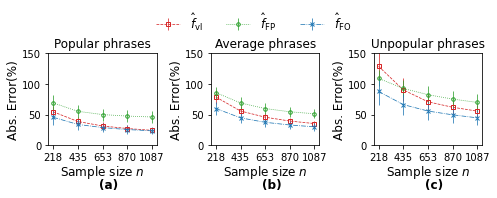

In [49]:
#Main

#PART 1 Functions
#Organizing the original data file
# parseFile('outputacm.txt')

#Creating the papers
# papers = createPapers()

#Creating the networks
# net = createNetwork(papers)
# revNet = createReverseNetwork(net)

#Creating nodes & edgelist
# nodes = identifyNodes(revNet)
# createEdgelist(net)

#Creating the graph
graph = createGraph()

#Determining in and out degree of nodes
# d_out = identifyOutDegreeOfNodes(nodes,revNet)
# d_in = identifyInDegreeOfNodes(nodes,net)

#PART 2 Functions
#Determining hashtags
#titlesInNetwork(nodes,papers)
#findKeyPhrases("average",30)
# phrases = getList('backupFiles/phrases.txt')
# titlesCount('backupFiles/phrases.txt')

#PART 3 Functions
#Identifying the sharing nodes and exposed nodes
# phrase = "Access Control"
# phrase = phrase.lower()
# shared = identifySharingNodes(phrase, papers, nodes)
# exposed =identifyExposedNodes(shared, net)

#Converting from dict to list
# Nodes = list(nodes.keys())
# d_out = list(d_out.values())
# d_in = list(d_in.values())
# s= list(shared.values())
# f= list(exposed.values())

# sum_degree_out = sum(d_out)
# sum_degree_in = sum(d_in)
# bar_d = sum(d_out)/len(d_out) 
# bar_f = sum(f)/len(f) 

#Performing estimation
# SaveError(graph,s,'access_control.txt')
# PlotError(graph,'access_control.txt')
PlotErrorAveragewith_error_bars(graph,'newEstimates')